# 0. 프로젝트 정의하기!

# 1. 데이터 확인하기!

In [46]:
import os
from os.path import join

from tqdm import tqdm #진행률바
import re
import optuna
from optuna.integration import XGBoostPruningCallback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bisect

from sklearn.preprocessing import  LabelEncoder #문자를 숫자로 인코딩
from sklearn.model_selection import TimeSeriesSplit #변수n을 입력, n번의 반복으로 교차검즘을 할 것인지 정하는 것

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge #선형 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

In [47]:
print(pd.__version__)

1.4.3


In [48]:
# 코랩
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/AIFFEL/Workspace/Project/Datathon/data'

# 로컬
data_dir = os.getenv('USERPROFILE') + '\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data'

In [49]:
train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_path, index_col=0).reset_index(drop=True)
test_X = pd.read_csv(test_path, index_col=0).reset_index(drop=True)

print(train.shape, test_X.shape)

(1216553, 13) (5463, 12)


In [50]:
train_copy = train.copy()

## 표본 추출을 통해 train 데이터의 수를 줄이겠습니다.
train = train.sample(frac=0.05, random_state=9)
train.shape

(60828, 13)

In [51]:
train.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
233536,5959,서울특별시,노원구,상계동,720,상계주공6(고층),상계동 720 상계주공6(고층),58.01,1988,201605,11~20,9,30000
309676,4399,서울특별시,강서구,신정동,326,목동신시가지12,신정동 326 목동신시가지12,71.64,1988,200908,21~31,9,59800
799304,1334,부산광역시,북구,구포동,1103-2,구포현대,구포동 1103-2 구포현대,61.20,1994,200803,1~10,3,8200
834293,8752,부산광역시,북구,화명동,1426-1,우신,화명동 1426-1 우신,57.26,1987,201503,11~20,5,16100
656397,6914,부산광역시,서구,암남동,81-12,송도자유비치,암남동 81-12 송도자유비치,59.79,1997,201202,11~20,11,10000


In [52]:
test_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,10453,서울특별시,강서구,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,989,부산광역시,동구,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,8597,부산광역시,사하구,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,11086,서울특별시,강남구,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,2121,부산광역시,사하구,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


데이터 정보

0. apartment_id: 아파트 아이디
1. city: 도시
2. dong: 동
3. jibun: 지번
4. apt: 아파트단지 이름
5. addr_kr: 주소
6. exclusive_use_area: 전용면적
7. year_of_completion: 설립일자
8. transaction_year_month: 거래년월
9. transaction_date: 거래날짜
10. floor: 층
11. transaction_real_price: 실거래가(train 만 존재)

<AxesSubplot:>

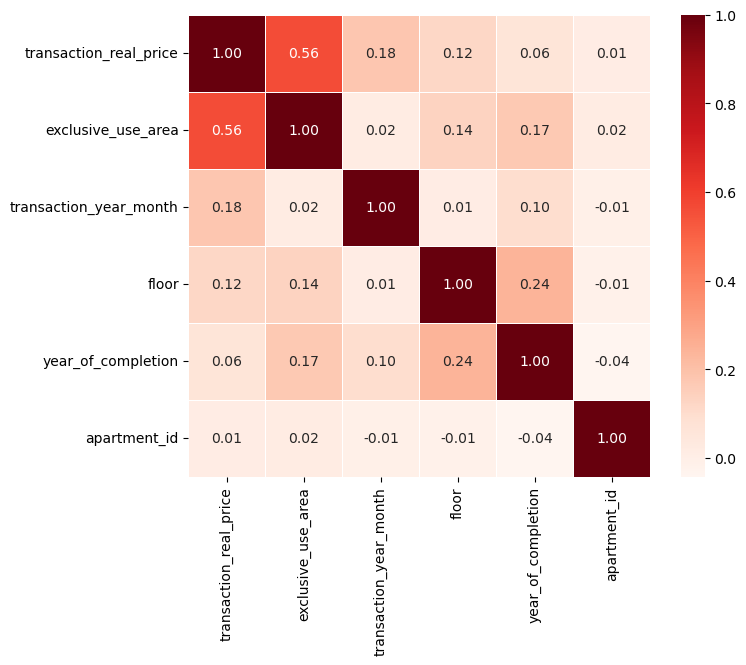

In [53]:
#상관관계 확인
k = train.shape[1] #히트맵 변수 갯수
corr_mat = train.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

# 2. train, test 데이터 합치기!

In [54]:
train_y = train['transaction_real_price']
print(train_y.head())

print(train.shape)
train_X = train.drop('transaction_real_price', axis=1)
print(train_X.shape)

233536    30000
309676    59800
799304     8200
834293    16100
656397    10000
Name: transaction_real_price, dtype: int64
(60828, 13)
(60828, 12)


In [55]:
whole_X = pd.concat((train_X, test_X), axis=0)
whole_X.shape

(66291, 12)

In [56]:
whole_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
233536,5959,서울특별시,노원구,상계동,720,상계주공6(고층),상계동 720 상계주공6(고층),58.01,1988,201605,11~20,9
309676,4399,서울특별시,강서구,신정동,326,목동신시가지12,신정동 326 목동신시가지12,71.64,1988,200908,21~31,9
799304,1334,부산광역시,북구,구포동,1103-2,구포현대,구포동 1103-2 구포현대,61.20,1994,200803,1~10,3
834293,8752,부산광역시,북구,화명동,1426-1,우신,화명동 1426-1 우신,57.26,1987,201503,11~20,5
656397,6914,부산광역시,서구,암남동,81-12,송도자유비치,암남동 81-12 송도자유비치,59.79,1997,201202,11~20,11


In [57]:
whole_X.describe()

,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,66291.000000,66291.000000,66291.000000,66291.000000,66291.000000
mean,6313.173251,78.150135,1998.507294,201333.375767,9.237966
std,3580.013258,29.539416,9.049267,300.136513,6.547386
min,2.000000,10.321500,1961.000000,200801.000000,-1.000000
25%,3351.000000,59.760000,1993.000000,201101.000000,4.000000
50%,5967.000000,81.760000,2000.000000,201405.000000,8.000000
75%,9436.000000,84.970000,2005.000000,201606.000000,13.000000
max,12654.000000,273.860000,2017.000000,201712.000000,80.000000


In [58]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66291 entries, 233536 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            66291 non-null  int64  
 1   city                    66291 non-null  object 
 2   gu                      66291 non-null  object 
 3   dong                    66291 non-null  object 
 4   jibun                   66291 non-null  object 
 5   apt                     66291 non-null  object 
 6   addr_kr                 66291 non-null  object 
 7   exclusive_use_area      66291 non-null  float64
 8   year_of_completion      66291 non-null  int64  
 9   transaction_year_month  66291 non-null  int64  
 10  transaction_date        66291 non-null  object 
 11  floor                   66291 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 6.6+ MB


# 3. 탐색적 자료 분석하기!

In [59]:
print(whole_X.shape)
whole_X = whole_X.drop(['jibun', 'apt', 'addr_kr', 'transaction_date'], axis=1)
print(whole_X.shape)

(66291, 12)
(66291, 8)


In [60]:
whole_X['year_of_completion'] = pd.to_datetime(whole_X['year_of_completion'].apply(lambda x: str(x)[:4])).dt.year

In [61]:
whole_X['year_of_completion']

233536    1988
309676    1988
799304    1994
834293    1987
656397    1997
          ... 
5458      2003
5459      2009
5460      2004
5461      2005
5462      1993
Name: year_of_completion, Length: 66291, dtype: int64

In [62]:
whole_X['transaction_year_month'] = pd.to_datetime(whole_X['transaction_year_month'].apply(lambda x: str(x)[:4])).dt.year

In [63]:
whole_X['transaction_year_month']

233536    2016
309676    2009
799304    2008
834293    2015
656397    2012
          ... 
5458      2017
5459      2017
5460      2017
5461      2017
5462      2017
Name: transaction_year_month, Length: 66291, dtype: int64

C:\Users\Hugh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='floor', ylabel='transaction_real_price'>

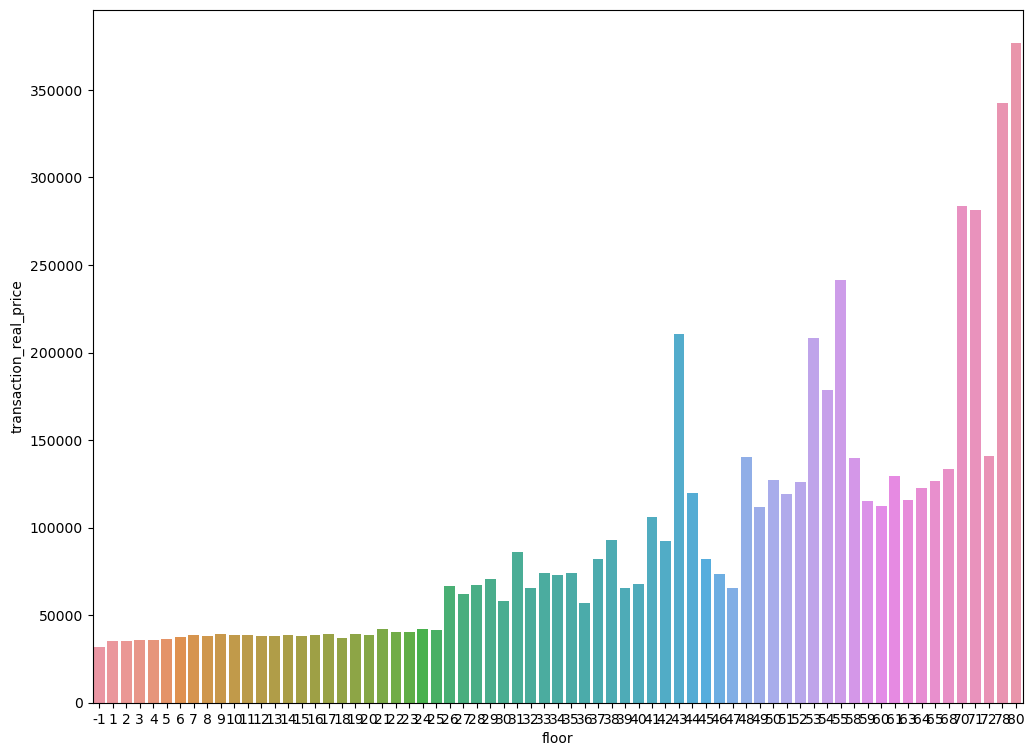

In [64]:
f, ax = plt.subplots(figsize=(12, 9))
group = train.groupby(['floor']).mean()['transaction_real_price']
sns.barplot(group.index, group)

In [65]:
whole_X['floor'].describe()

count    66291.000000
mean         9.237966
std          6.547386
min         -1.000000
25%          4.000000
50%          8.000000
75%         13.000000
max         80.000000
Name: floor, dtype: float64

In [66]:
whole_X['floor'] = whole_X['floor'] + 4
whole_X['floor'].head()

233536    13
309676    13
799304     7
834293     9
656397    15
Name: floor, dtype: int64

In [67]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66291 entries, 233536 to 5462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            66291 non-null  int64  
 1   city                    66291 non-null  object 
 2   gu                      66291 non-null  object 
 3   dong                    66291 non-null  object 
 4   exclusive_use_area      66291 non-null  float64
 5   year_of_completion      66291 non-null  int64  
 6   transaction_year_month  66291 non-null  int64  
 7   floor                   66291 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 4.6+ MB


In [68]:
# fig, ax = plt.subplots(4, 2, figsize=(12, 18))

# columns = whole_X.columns
# count = 0
# for row in range(4):
#     for col in range(2):
#         sns.kdeplot(data=whole_X[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count += 1
#         if count == whole_X.shape[1]:
#             break
            
# plt.show()

In [69]:
train_y.values

array([30000, 59800,  8200, ..., 19500, 41900, 47500], dtype=int64)

In [70]:
train_temp = whole_X.iloc[:len(train), :]

train_temp.loc[:, 'transaction_real_price'] = train_y.values
train_temp.head()

C:\Users\Hugh\AppData\Local\Temp\ipykernel_7960\458979734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_temp.loc[:, 'transaction_real_price'] = train_y.values


,apartment_id,city,gu,dong,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
233536,5959,서울특별시,노원구,상계동,58.01,1988,2016,13,30000
309676,4399,서울특별시,강서구,신정동,71.64,1988,2009,13,59800
799304,1334,부산광역시,북구,구포동,61.20,1994,2008,7,8200
834293,8752,부산광역시,북구,화명동,57.26,1987,2015,9,16100
656397,6914,부산광역시,서구,암남동,59.79,1997,2012,15,10000


<AxesSubplot:>

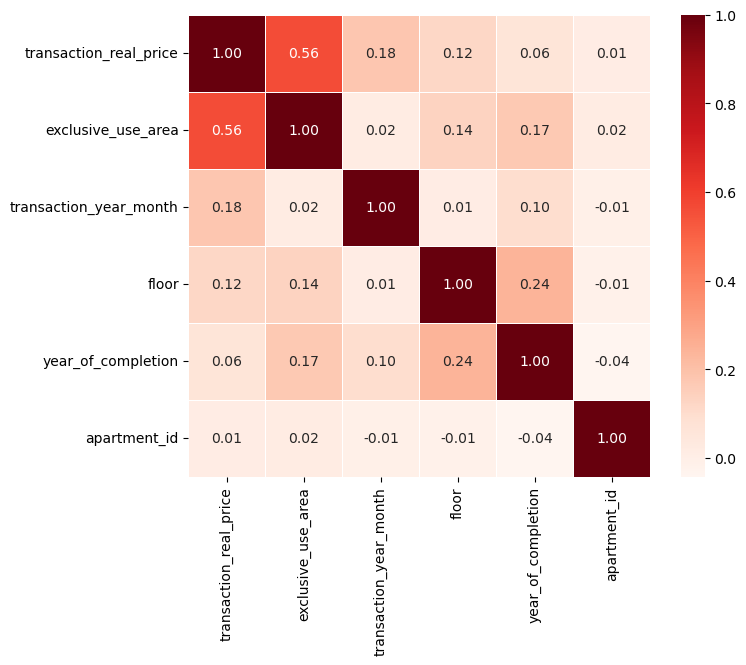

In [71]:
#상관관계 확인
k = train_temp.shape[1] #히트맵 변수 갯수
corr_mat = train_temp.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train_temp[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [72]:
skew_columns = ['exclusive_use_area', 'floor']

for column in skew_columns:
    whole_X[column] = np.log1p(whole_X[column].values)

<AxesSubplot:xlabel='apartment_id', ylabel='Count'>

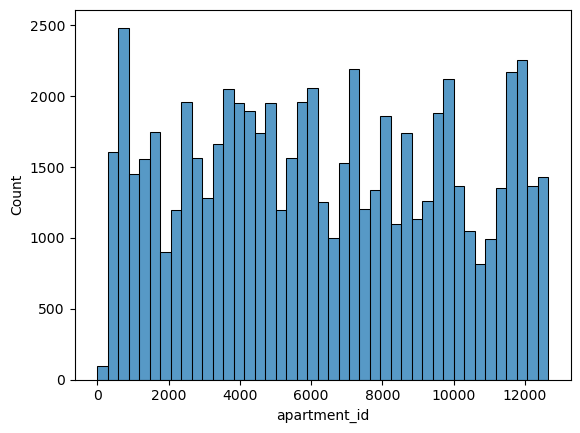

In [73]:
sns.histplot(whole_X['apartment_id'])

<AxesSubplot:xlabel='exclusive_use_area', ylabel='Count'>

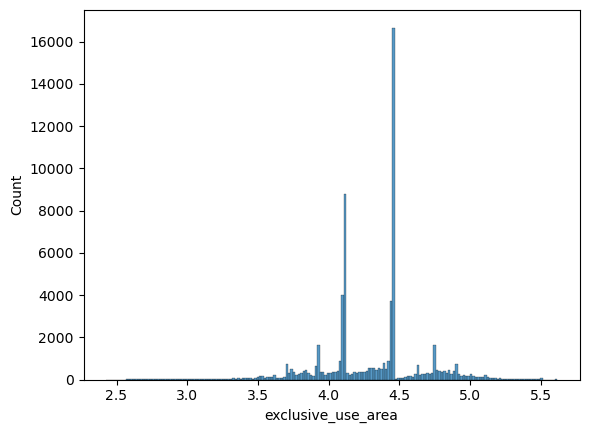

In [74]:
sns.histplot(whole_X['exclusive_use_area'])

<AxesSubplot:xlabel='floor', ylabel='Count'>

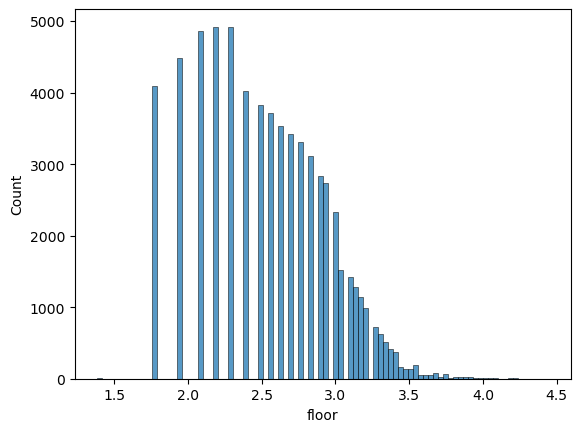

In [75]:
sns.histplot(whole_X['floor'])

In [76]:
whole_X.columns

Index(['apartment_id', 'city', 'gu', 'dong', 'exclusive_use_area',
       'year_of_completion', 'transaction_year_month', 'floor'],
      dtype='object')

In [77]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66291 entries, 233536 to 5462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            66291 non-null  int64  
 1   city                    66291 non-null  object 
 2   gu                      66291 non-null  object 
 3   dong                    66291 non-null  object 
 4   exclusive_use_area      66291 non-null  float64
 5   year_of_completion      66291 non-null  int64  
 6   transaction_year_month  66291 non-null  int64  
 7   floor                   66291 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.6+ MB


In [78]:
whole_X

,apartment_id,city,gu,dong,exclusive_use_area,year_of_completion,transaction_year_month,floor
233536,5959,서울특별시,노원구,상계동,4.077707,1988,2016,2.639057
309676,4399,서울특별시,강서구,신정동,4.285516,1988,2009,2.639057
799304,1334,부산광역시,북구,구포동,4.130355,1994,2008,2.079442
834293,8752,부산광역시,북구,화명동,4.064916,1987,2015,2.302585
656397,6914,부산광역시,서구,암남동,4.107425,1997,2012,2.772589
...,...,...,...,...,...,...,...,...
5458,8965,서울특별시,강남구,양재동,4.443239,2003,2017,2.484907
5459,3831,서울특별시,강남구,반포동,4.453533,2009,2017,2.197225
5460,5550,서울특별시,구로구,구로동,4.711222,2004,2017,3.332205
5461,3371,서울특별시,서대문구,홍제동,4.537320,2005,2017,1.791759


In [79]:
whole_X_onehot = pd.get_dummies(whole_X, columns=['apartment_id', 'city', 'gu', 'dong', 'year_of_completion', 'transaction_year_month'])

In [80]:
whole_X_onehot

,exclusive_use_area,floor,apartment_id_2,apartment_id_5,apartment_id_12,apartment_id_14,apartment_id_17,apartment_id_18,apartment_id_19,apartment_id_20,...,transaction_year_month_2008,transaction_year_month_2009,transaction_year_month_2010,transaction_year_month_2011,transaction_year_month_2012,transaction_year_month_2013,transaction_year_month_2014,transaction_year_month_2015,transaction_year_month_2016,transaction_year_month_2017
233536,4.077707,2.639057,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
309676,4.285516,2.639057,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
799304,4.130355,2.079442,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
834293,4.064916,2.302585,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
656397,4.107425,2.772589,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,4.443239,2.484907,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5459,4.453533,2.197225,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5460,4.711222,3.332205,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5461,4.537320,1.791759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [81]:
train_y.describe()

count     60828.000000
mean      38250.835027
std       31332.999667
min        1000.000000
25%       19000.000000
50%       31000.000000
75%       47000.000000
max      650000.000000
Name: transaction_real_price, dtype: float64

train_y -> Skewness: 3.526791, Kurtosis: 24.890904


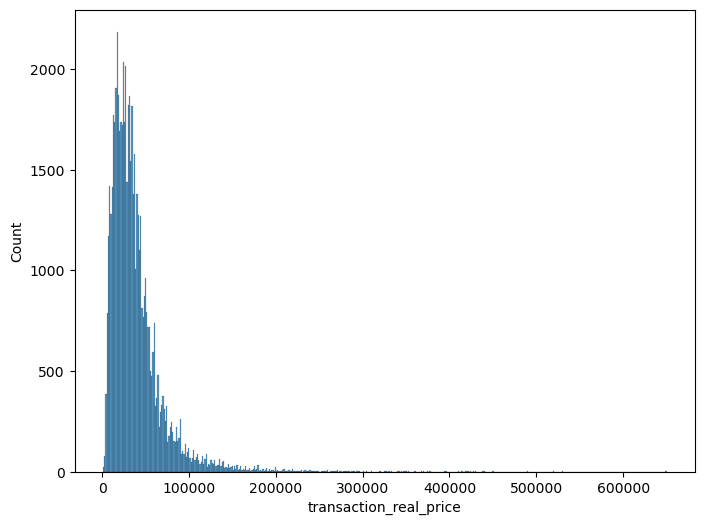

In [82]:
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

In [83]:
train_y = np.log1p(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

train_y -> Skewness: -0.087722, Kurtosis: 0.246559


<AxesSubplot:xlabel='transaction_real_price', ylabel='Count'>

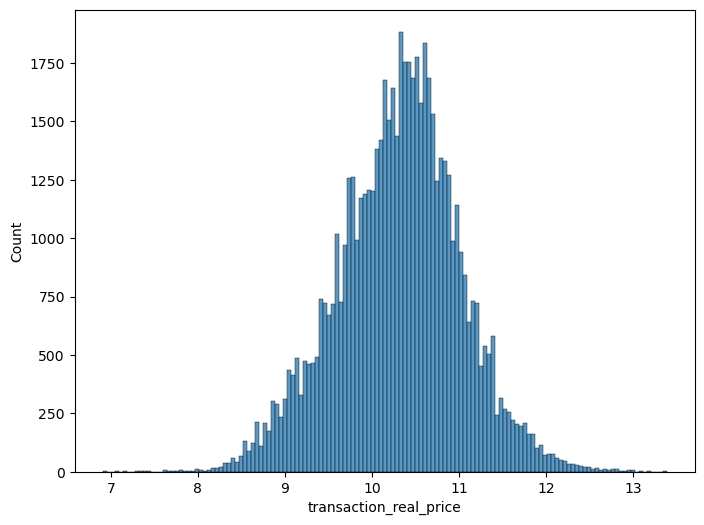

In [84]:
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)

In [85]:
train_X = whole_X_onehot.iloc[:len(train), :]
test_X = whole_X_onehot.iloc[len(train):, :]

print(train_X.shape)
print(test_X.shape)

(60828, 9348)
(5463, 9348)


In [86]:
train_X.head()

,exclusive_use_area,floor,apartment_id_2,apartment_id_5,apartment_id_12,apartment_id_14,apartment_id_17,apartment_id_18,apartment_id_19,apartment_id_20,...,transaction_year_month_2008,transaction_year_month_2009,transaction_year_month_2010,transaction_year_month_2011,transaction_year_month_2012,transaction_year_month_2013,transaction_year_month_2014,transaction_year_month_2015,transaction_year_month_2016,transaction_year_month_2017
233536,4.077707,2.639057,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
309676,4.285516,2.639057,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
799304,4.130355,2.079442,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
834293,4.064916,2.302585,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
656397,4.107425,2.772589,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [87]:
def my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train_X, train_y)

    # 퍙기 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 평가 결과를 담을 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-results['score'])
    results = results.sort_values('RMSLE')

    return results

In [88]:
random_state = 9

In [89]:
# model = LGBMRegressor(random_state=random_state)

# param_grid = {
#     'n_estimators': [2400, 2500], # 2500
#     'max_depth': [20, 19], # 19
#     # 'num_leaves': [34, 35], # 35
#     # 'min_child_samples': [16, 18], # 18
# }
# my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7)

In [90]:
def tsize(train_X): # 지극히 주관적인 적당한 test size 값 찾는 함수
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

In [91]:
def rmse(y_test, y_pred): # RMSE 손실 함수
    # 로그를 씌웠던 레이블에 다시 지수를 씌워서 스케일을 원상복구하고 평가하기
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [92]:
def get_scores(models, train_X, train_y):
    scores = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=random_state, test_size=tsize(train_X))
        
        scaler = RobustScaler() # 표준화 스케일러
        X_train = scaler.fit_transform(X_train) # X_train 데이터를 fit과 동시에 transform
        X_test = scaler.transform(X_test) # X_test 데이터를 transform
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores[model_name] = rmse(y_test, y_pred) # 모델 별 RMSE 값 계산
        scores_df = pd.DataFrame(scores, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return scores_df

In [93]:
def save_submission(last_model, train_X, train_y, test_X, n):
    last_model.fit(train_X, train_y)
    test_y = last_model.predict(test_X)
    test_y = np.expm1(test_y) # 스케일 원상복구
    data_dir = os.getenv('USERPROFILE')+'\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data'
    # data_dir = '/content/drive/MyDrive/AIFFEL/Workspace/Project/Datathon/data'
    submission_path = join(data_dir, 'submission.csv')
    submission = pd.read_csv(submission_path)
    submission['transaction_real_price'] = test_y

    submission_csv_path = '{}\submission_{}.csv'.format(data_dir, n)
    # submission_csv_path = '{}/submission_{}.csv'.format(data_dir, n)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [94]:
last_model = LGBMRegressor(max_depth=20, n_estimators=2500, min_child_samples=16, num_leaves=35)

In [96]:
save_submission(last_model, train_X, train_y, test_X, 1)

C:\Users\Hugh\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data\submission_1.csv saved!
